In [ ]:
###########################
###  GROUP MEMBERS  ###
# 19i_2199 Syed Abu Bakr
# 19i_0545 Ahmed Ali
# 19i_2194 Faiez Malik
###########################
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow

# PREPROCESSING
Grayscale conversion, Gaussian blur and Canny edge detetction

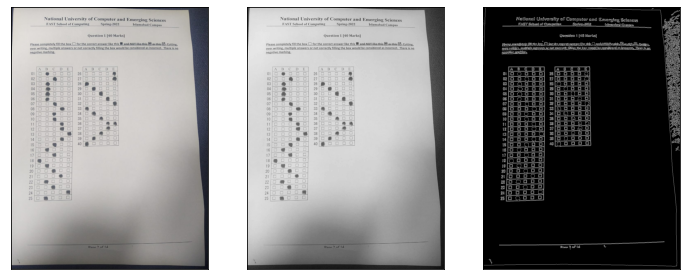

In [ ]:
img = imread("solution.jpeg")
grayscale= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
blur = cv2.GaussianBlur(grayscale,(5,5),1)
canny = cv2.Canny(blur,10,50) 

#displaying images side by side
f, axarr = plt.subplots(1,3, figsize=(12, 12))

axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(grayscale, cmap='gray')
axarr[2].imshow(canny, cmap='gray')
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])


# Contours

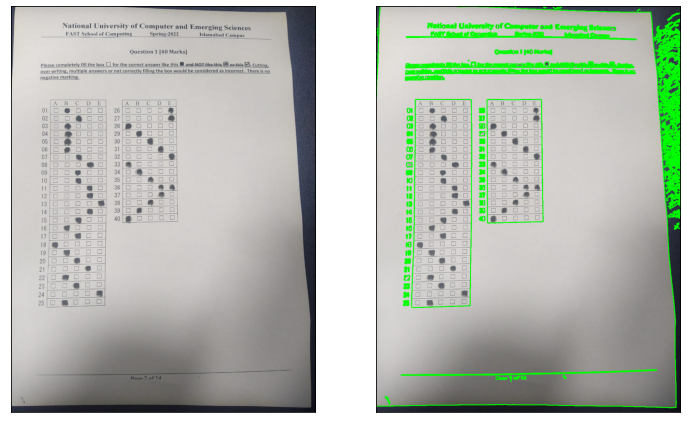

In [ ]:
contour, hierarchy = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
imgC = img.copy()
imgContour = cv2.drawContours(imgC,contour,-1,(0,255,0),2)

# #displaying images side by side
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(imgContour, cmap='gray')
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

# Finding Rectangle Contours of all the MCQ's

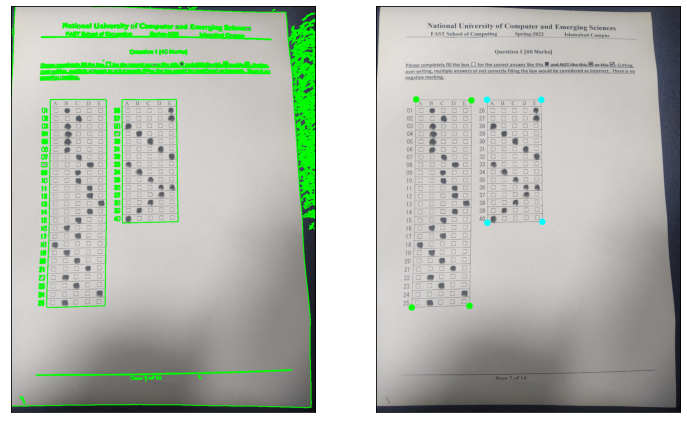

In [ ]:
def getpoints(c):
  peri = cv2.arcLength(c,True)
  return cv2.approxPolyDP(c,0.02*peri,True)

def rectangle_Counter(c):
  rectCont=[]
  for i in c:
    area= cv2.contourArea(i)
    if area>50:
      approx = getpoints(i)
      #print(len(approx))
      if(len(approx)==4):
        rectCont.append(i)
  rectCont = sorted(rectCont,key=cv2.contourArea,reverse=True)
  return rectCont

rectCont = rectangle_Counter(contour)
pane1 = getpoints(rectCont[0])
pane2 = getpoints(rectCont[1])
#print(pane1)

#for displaying purposes
imgPanes=img.copy()
if pane1.size != 0 and pane2.size != 0:
  cv2.drawContours(imgPanes,pane1,-1,(0,255,0),20)
  cv2.drawContours(imgPanes,pane2,-1,(0,255,255),20)

  # #displaying images side by side
  f, axarr = plt.subplots(1,2, figsize=(12, 12))
  axarr[0].imshow(imgContour, cmap='gray')
  axarr[1].imshow(imgPanes, cmap='gray')
  for ax in axarr:
      ax.set_xticks([])
      ax.set_yticks([])


# Perspective Warping of the MCQ Panes

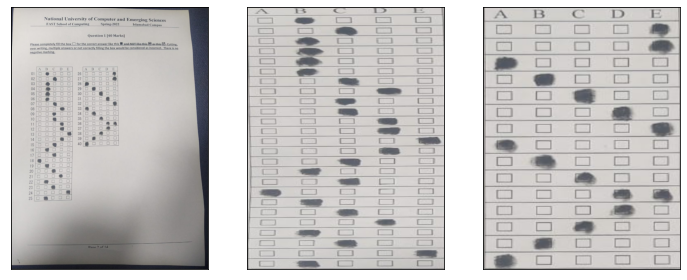

In [ ]:
def reorder(p):
  p = p.reshape((4,2))
  arranged = np.zeros((4,1,2),np.int32) # aeeay of arranged points
  add= p.sum(1)
  arranged[0] = p[np.argmin(add)] #top left point [0,0]
  arranged[3] = p[np.argmax(add)] #bottom right point [w,h]

  diff=np.diff(p,axis=1)
  arranged[1] = p[np.argmin(diff)] #top right point [w,0]
  arranged[2] = p[np.argmax(diff)] #bottom left point [0,h]
  return arranged

if pane1.size != 0 and pane2.size != 0:
  pane1 = reorder(pane1)
  pane2 = reorder(pane2)
  
  x=img.shape[1]
  y=img.shape[0]
  pt1 = np.float32(pane1)
  pt2 = np.float32([[0,0],[x,0],[0,y],[x,y]])
  imgWarp = cv2.warpPerspective(img,cv2.getPerspectiveTransform(pt1,pt2),(x,y))

  pt11 = np.float32(pane2)
  pt22 = np.float32([[0,0],[x,0],[0,y],[x,y]])
  imgWarp2 = cv2.warpPerspective(img,cv2.getPerspectiveTransform(pt11,pt22),(x,y))

  #displaying images side by side
  f, axarr = plt.subplots(1,3, figsize=(12, 12))
  axarr[0].imshow(img, cmap='gray')
  axarr[1].imshow(imgWarp, cmap='gray')
  axarr[2].imshow(imgWarp2, cmap='gray')
  for ax in axarr:
      ax.set_xticks([])
      ax.set_yticks([])

# Applying threshold on the MCQ Panes to obtain a  binary image

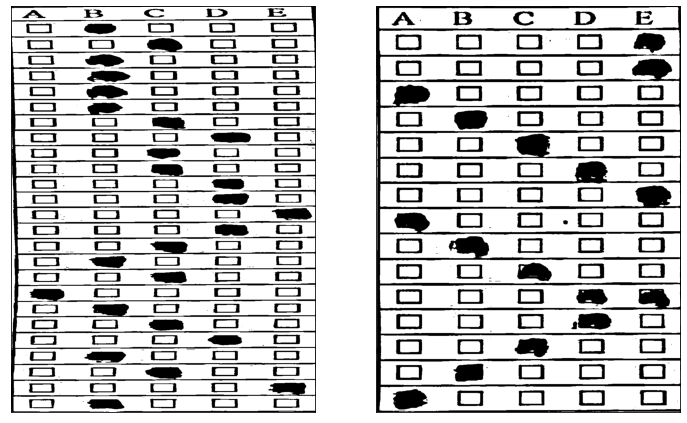

In [ ]:
if len(imgWarp.shape)==3: 
  imgWarp = cv2.cvtColor(imgWarp, cv2.COLOR_BGR2GRAY)
if len(imgWarp2.shape)==3: 
  imgWarp2 = cv2.cvtColor(imgWarp2, cv2.COLOR_BGR2GRAY)
threshold_pane1= cv2.adaptiveThreshold(imgWarp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,127,2)
threshold_pane2= cv2.adaptiveThreshold(imgWarp2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,127,2)

f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(threshold_pane1, cmap='gray')
axarr[1].imshow(threshold_pane2, cmap='gray')
for ax in axarr:
  ax.set_xticks([])
  ax.set_yticks([])

# Detecting choices of the user by counting black pixels in a single checkbox for **PANE 1**

['b', 'c', 'b', 'b', 'b', 'b', 'c', 'd', 'c', 'c', 'd', 'd', 'e', 'd', 'c', 'b', 'c', 'a', 'b', 'c', 'd', 'b', 'c', 'e', 'b']


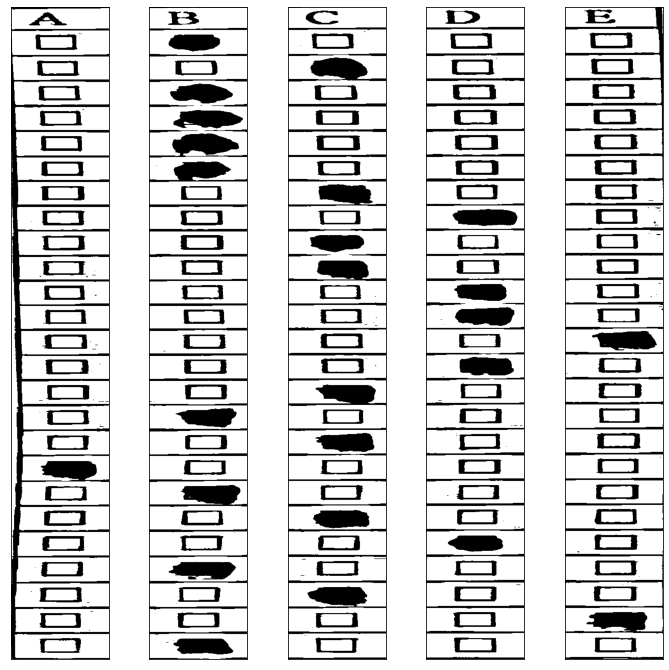

In [ ]:
##########################################
# 1st arg is the img
# 2nd arg is the number of rows to be split in the img
# 3rd arg is the threshold of black pixels that determines a valid choice
##########################################
def detectchoice(binary_img,split,pthres): 
  cols = np.hsplit(binary_img,5)

  #cropping the vertical black error lines at the start and end 
  cols[0] = cols[0][:,10:]
  cols[4] = cols[4][:,:178]

  #addition is the number of pixels that are incremented in each iteration
  addition = int(binary_img.shape[0]/split)
  boxs = []
  for c in cols:
    row_increment = 0
    for i in range(split):
      #horizontally splitting to get each choice
      box= c[row_increment:row_increment+addition,:]
      row_increment= row_increment+addition
      boxs.append(box)

  choices = []
  for i in range(1,split):
    choice = ""
    #boxA
    pixels = boxs[i].shape[0] * boxs[i].shape[1]
    white = cv2.countNonZero(boxs[i])
    black = pixels - white
    if (black >= pthres):
      choice = "a"
    #boxB
    pixels = boxs[i+split].shape[0] * boxs[i+split].shape[1]
    white = cv2.countNonZero(boxs[i+split])
    black = pixels - white
    if (black >= pthres):
      if(choice != ""):
        choices.append("M")#Multiple Selections
        continue
      choice = "b"
    #boxC
    pixels = boxs[i+(2*split)].shape[0] * boxs[i+(2*split)].shape[1]
    white = cv2.countNonZero(boxs[i+(2*split)])
    black = pixels - white
    if (black >= pthres):
      if(choice != ""):
        choices.append("M")#Multiple Selections
        continue
      choice = "c"
    #boxD
    pixels = boxs[i+(3*split)].shape[0] * boxs[i+(3*split)].shape[1]
    white = cv2.countNonZero(boxs[i+(3*split)])
    black = pixels - white
    if (black >= pthres):
      if(choice != ""):
        choices.append("M")#Multiple Selections
        continue
      choice = "d"
    #boxE
    pixels = boxs[i+(4*split)].shape[0] * boxs[i+(4*split)].shape[1]
    white = cv2.countNonZero(boxs[i+(4*split)])
    black = pixels - white
    if (black >= pthres):
      if(choice != ""):
        choices.append("M")#Multiple Selections
        continue
      choice = "e"
    choices.append(choice)
  return choices


mychoice1 = detectchoice(threshold_pane1,26,3000)
cols = np.hsplit(threshold_pane1,5)
print(mychoice1)
f, axarr = plt.subplots(1,5, figsize=(12, 12))
axarr[0].imshow(cols[0], cmap='gray')
axarr[1].imshow(cols[1], cmap='gray')
axarr[2].imshow(cols[2], cmap='gray')
axarr[3].imshow(cols[3], cmap='gray')
axarr[4].imshow(cols[4], cmap='gray')
for ax in axarr:
  ax.set_xticks([])
  ax.set_yticks([])



# Detecting choices of the user by counting black pixels in a single box for **PANE 2**

['e', 'e', 'a', 'b', 'c', 'd', 'e', 'a', 'b', 'c', 'M', 'd', 'c', 'b', 'a']


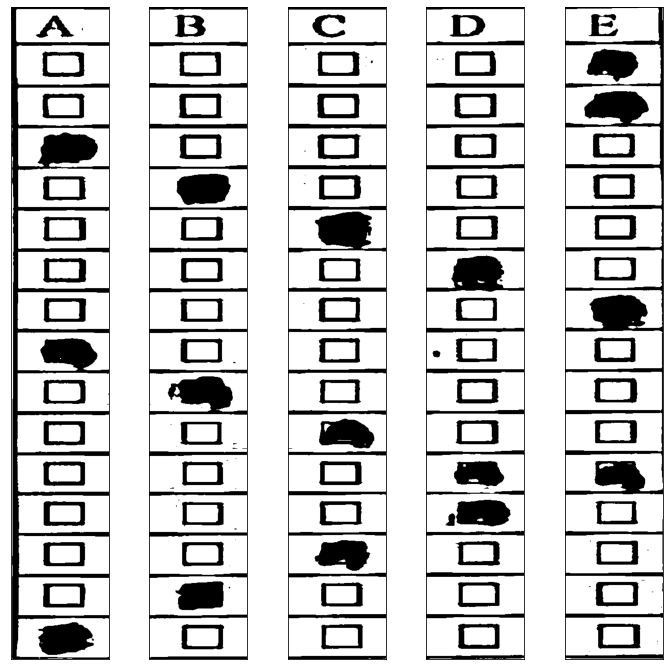

In [ ]:
mychoice2 = detectchoice(threshold_pane2,16,3800)
cols = np.hsplit(threshold_pane2,5)
print(mychoice2)
f, axarr = plt.subplots(1,5, figsize=(12, 12))
axarr[0].imshow(cols[0], cmap='gray')
axarr[1].imshow(cols[1], cmap='gray')
axarr[2].imshow(cols[2], cmap='gray')
axarr[3].imshow(cols[3], cmap='gray')
axarr[4].imshow(cols[4], cmap='gray')
for ax in axarr:
  ax.set_xticks([])
  ax.set_yticks([])

# **Results !!!**

In [ ]:
key = ['b', 'c', 'b', 'b', 'b', 'b', 'c', 'd', 'c', 'c', 'd', 'd', 'e', 'd', 'c', 'b', 'c', 'a', 'b', 'c', 'd', 'b', 'c', 'e', 'b','e', 'e', 'a', 'b', 'c', 'd', 'e', 'a', 'b', 'c', 'M', 'd', 'c', 'b', 'a']
mychoices = mychoice1 + mychoice2
#marks calculation
marks = 0
for i in range(40):
  if key[i]==mychoices[i] and mychoices!="M":
    marks=marks+1
print(marks)

40
